In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.5 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 - Training Loss: 6.2450
Epoch 1 - Validation Loss: 2.6709
Epoch 2 - Training Loss: 3.0824
Epoch 2 - Validation Loss: 1.9512
Epoch 3 - Training Loss: 2.0211
Epoch 3 - Validation Loss: 1.5350
Epoch 4 - Training Loss: 1.4055
Epoch 4 - Validation Loss: 1.3637
Epoch 5 - Training Loss: 1.1452
Epoch 5 - Validation Loss: 1.3015
Epoch 6 - Training Loss: 1.0365
Epoch 6 - Validation Loss: 1.2804
Epoch 7 - Training Loss: 0.9626
Epoch 7 - Validation Loss: 1.2364
Target: "The Hindu undivided family consisted of Budd Appa, his wife, two unmarried daughters, and his adopted son, Buddanna. The issue raised was whether the sole male surviving coparcener of the Hindu joint family, his widowed mother, and sisters constitute a Hindu undivided family within the meaning of the Income-tax Act, and whether the assessment of the income in the hands of the Hindu undivided family was correct. In this case, the property that yielded the income originally belonged to a Hindu undivided family. Upon the death

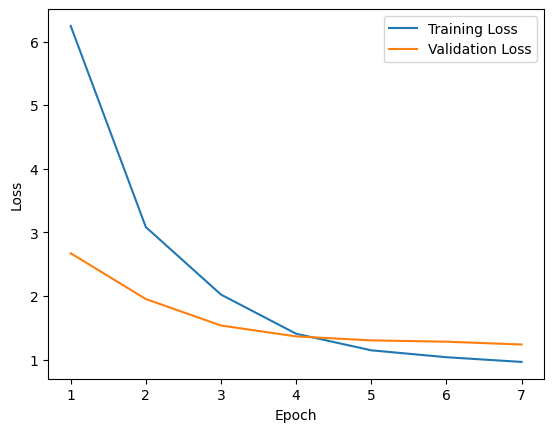

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BartTokenizer, BartForConditionalGeneration, AdamW
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

# Step 1: Load the Dataset
df = pd.read_excel("/content/Golden_summary.xlsx")

# Step 2: Split the Dataset into Train, Test, and Validation Sets
train_text, test_text, train_summary, test_summary = train_test_split(
    df['Judgment'], df['Golden summary'], test_size=0.2, random_state=42
)
test_text, val_text, test_summary, val_summary = train_test_split(
    test_text, test_summary, test_size=0.5, random_state=42
)

# Step 3: Load the BART Model and Tokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

# Step 4: Tokenize the Data
train_encodings = tokenizer(list(train_text), truncation=True, padding=True)
train_labels = tokenizer(list(train_summary.astype(str)), truncation=True, padding=True)

val_encodings = tokenizer(list(val_text), truncation=True, padding=True)
val_labels = tokenizer(list(val_summary.astype(str)), truncation=True, padding=True)

test_encodings = tokenizer(list(test_text), truncation=True, padding=True)
test_labels = tokenizer(list(test_summary.astype(str)), truncation=True, padding=True)


# Step 5: Create PyTorch Datasets
class SummaryDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels['input_ids'][idx])
        return item

    def __len__(self):
        return len(self.labels['input_ids'])

train_dataset = SummaryDataset(train_encodings, train_labels)
val_dataset = SummaryDataset(val_encodings, val_labels)
test_dataset = SummaryDataset(test_encodings, test_labels)

# Step 6: Fine-tune the BART Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)

optimizer = AdamW(model.parameters(), lr=1e-5)

num_epochs = 7

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    total_loss = 0
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} - Training Loss: {avg_loss:.4f}")

    # Step 7: Evaluation on Validation Set
    model.eval()

    val_loader = DataLoader(val_dataset, batch_size=3, shuffle=False)

    total_val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1} - Validation Loss: {avg_val_loss:.4f}")


# Step 8: Generate Predictions on Test Set
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False)

predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)


        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=200)
        batch_preds = [tokenizer.decode(ids, skip_special_tokens=True) for ids in outputs]
        predictions.extend(batch_preds)


# Step 9: Evaluate Predictions
test_summary_list = test_summary.tolist()

for i in range(len(predictions)):
    print(f"Target: {test_summary_list[i]}")
    print(f"Prediction: {predictions[i]}")
    print("=" * 5)

# Plotting the Losses
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BartTokenizer, BartForConditionalGeneration, AdamW
from torch.utils.data import DataLoader, Dataset

df = pd.read_excel("/content/Golden_summary.xlsx")


test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False)

predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=200)
        batch_preds = [tokenizer.decode(ids, skip_special_tokens=True) for ids in outputs]
        predictions.extend(batch_preds)

predictions_df = pd.DataFrame({'Target Summary': test_summary_list, 'Predicted Summary': predictions})

predictions_df.to_excel("/content/Predicted_summaries.xlsx", index=False)


In [ ]:
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from rouge import Rouge


references = []
hypotheses = []

for i in range(len(predictions)):
    reference = test_summary_list[i]
    hypothesis = predictions[i]
    references.append(reference)
    hypotheses.append(hypothesis)


rouge = Rouge()


scores = rouge.get_scores(hypotheses, references, avg=True)


rouge_1_score = scores['rouge-1']
rouge_2_score = scores['rouge-2']
rouge_l_score = scores['rouge-l']

print(f"ROUGE-1 Score: {rouge_1_score}")
print(f"ROUGE-2 Score: {rouge_2_score}")
print(f"ROUGE-L Score: {rouge_l_score}")


ROUGE-1 Score: {'r': 0.37533095913885767, 'p': 0.4478926161662927, 'f': 0.3999930734430826}
ROUGE-2 Score: {'r': 0.18909349278985702, 'p': 0.23671125082452027, 'f': 0.20487673370964066}
ROUGE-L Score: {'r': 0.34984184078362557, 'p': 0.4187174856283379, 'f': 0.3732784385205676}


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


references = test_summary_list
hypotheses = predictions


tfidf_vectorizer = TfidfVectorizer()
vectorized_references = tfidf_vectorizer.fit_transform(references)
vectorized_hypotheses = tfidf_vectorizer.transform(hypotheses)


cosine_similarities = cosine_similarity(vectorized_references, vectorized_hypotheses)

average_cosine_similarity = np.mean(cosine_similarities)


print(f"Average Cosine Similarity: {average_cosine_similarity:.4f}")


Average Cosine Similarity: 0.3292
